Useful links:
- https://docs.nvidia.com/nsight-compute/NsightComputeCli/index.html#nvprof-metric-comparison
- https://docs.nvidia.com/cuda/profiler-users-guide/index.html#metrics-reference-7x
- https://canvas.kth.se/courses/36161/assignments/223741
- https://canvas.kth.se/courses/36161/pages/tutorial-timing-your-kernel-cpu-timer-and-nvprof?module_item_id=561394

In [ ]:
!nvcc --version
!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
Sat Jan  7 12:54:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0    28W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |      

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Colab Notebooks/DD2360 Applied GPU Programming KTH/hw_3/ex_2'
!ls

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/DD2360 Applied GPU Programming KTH/hw_3/ex_2
hw3_ex2_2D_dense_matrix_multiplication.ipynb  lab3_ex2	lab3_ex2.cu


In [ ]:
!nvcc -arch=sm_75 ./lab3_ex2.cu -o lab3_ex2
!./lab3_ex2 511 1023 1023 4094

Input matrix dim (511 x 1023) (1023 x 4094) (511 x 4094)
CPU and GPU results are equal.


In [ ]:
!/usr/local/cuda-11/bin/nv-nsight-cu-cli ./lab3_ex2 511 1023 1023 4094

Input matrix dim (511 x 1023) (1023 x 4094) (511 x 4094)
==PROF== Connected to process 1407 (/content/drive/MyDrive/Colab Notebooks/DD2360 Applied GPU Programming KTH/hw_3/ex_2/lab3_ex2)
==PROF== Profiling "gemm" - 1: 0%....50%....100% - 8 passes
CPU and GPU results are equal.
==PROF== Disconnected from process 1407
[1407] lab3_ex2@127.0.0.1
  gemm(float*, float*, float*, int, int, int, int), 2022-Nov-30 12:39:06, Context 1, Stream 7
    Section: GPU Speed Of Light
    ---------------------------------------------------------------------- --------------- ------------------------------
    DRAM Frequency                                                           cycle/nsecond                           4.99
    SM Frequency                                                             cycle/usecond                         584.85
    Elapsed Cycles                                                                   cycle                      8,753,354
    Memory [%]                            

In [ ]:
!nvprof ./lab3_ex2 2048 1536 1536 4096

Input matrix dim (2048 x 1536) (1536 x 4096) (2048 x 4096)
==1694== NVPROF is profiling process 1694, command: ./lab3_ex2 2048 1536 1536 4096
CPU and GPU results are NOT equal.
==1694== Profiling application: ./lab3_ex2 2048 1536 1536 4096
==1694== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   79.49%  112.18ms         1  112.18ms  112.18ms  112.18ms  gemm(float*, float*, float*, int, int, int, int)
                   14.03%  19.800ms         1  19.800ms  19.800ms  19.800ms  [CUDA memcpy DtoH]
                    6.48%  9.1401ms         2  4.5701ms  3.3573ms  5.7829ms  [CUDA memcpy HtoD]
      API calls:   58.91%  208.31ms         3  69.436ms  205.50us  207.79ms  cudaMalloc
                   40.42%  142.93ms         3  47.642ms  3.6210ms  133.27ms  cudaMemcpy
                    0.50%  1.7697ms         3  589.90us  158.61us  1.0516ms  cudaFree
                    0.10%  351.33us         1  351.33us  351.33us  351.

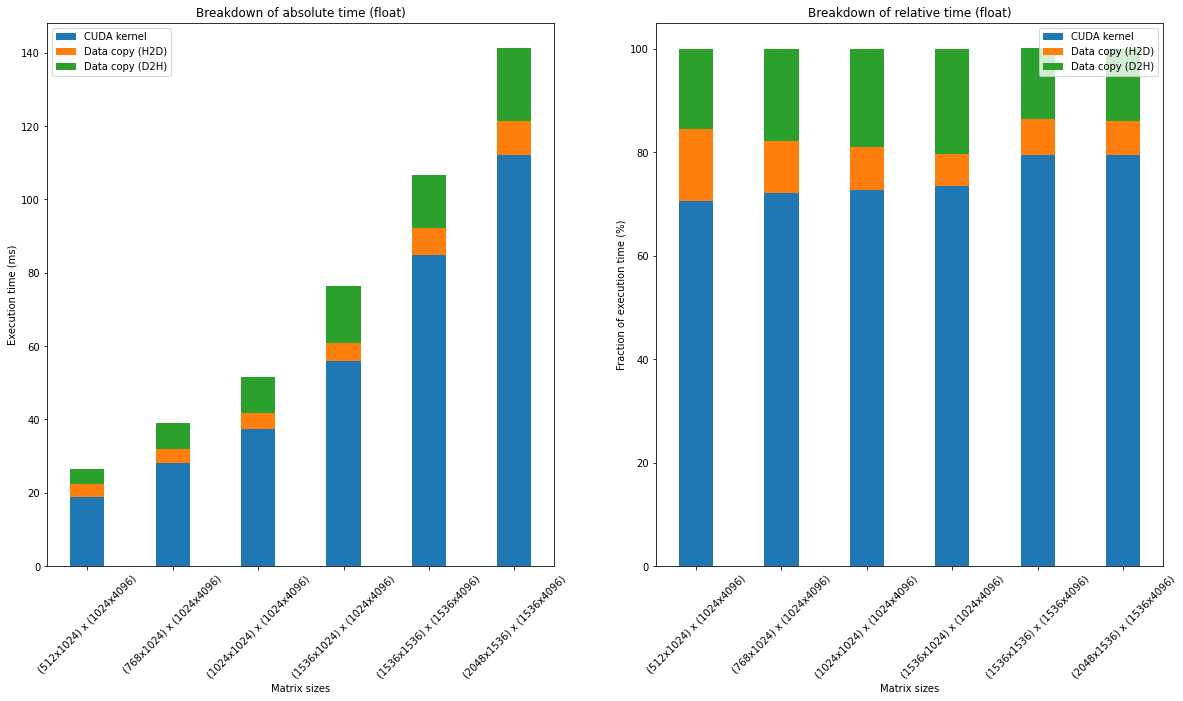

In [ ]:
# DATATYPE FLOAT
import matplotlib.pyplot as plt
import numpy as np

matrix_sizes = ['(512x1024) x (1024x4096)', '(768x1024) x (1024x4096)', '(1024x1024) x (1024x4096)',
                '(1536x1024) x (1024x4096)', '(1536x1536) x (1536x4096)', '(2048x1536) x (1536x4096)']
cuda_kernel_abs = np.array([18.735, 28.069, 37.398, 56.066, 84.762, 112.18])
datacpy_d2h_abs = np.array([4.1418, 6.9525, 9.7461, 15.564, 14.428, 19.800])
datacpy_h2d_abs = np.array([3.6500, 3.9571, 4.3047, 4.7697, 7.4046, 9.1401])

cuda_kernel_rel = np.array([70.63, 72.01, 72.69, 73.39, 79.52, 79.49])
datacpy_d2h_rel = np.array([15.61, 17.84, 18.94, 20.37, 13.54, 14.03])
datacpy_h2d_rel = np.array([13.76, 10.15,  8.37,  6.24,  6.95,  6.48])

width = 0.4
fig, ax = plt.subplots(1, 2)

ax[0].bar(matrix_sizes, cuda_kernel_abs, width, label='CUDA kernel')
ax[0].bar(matrix_sizes, datacpy_h2d_abs, width, bottom=cuda_kernel_abs,
       label='Data copy (H2D)')
ax[0].bar(matrix_sizes, datacpy_d2h_abs, width, bottom=datacpy_h2d_abs+cuda_kernel_abs,
       label='Data copy (D2H)')

ax[0].set_xlabel('Matrix sizes')
ax[0].set_ylabel('Execution time (ms)')
ax[0].set_title('Breakdown of absolute time (float)')
ax[0].legend()

ax[1].bar(matrix_sizes, cuda_kernel_rel, width, label='CUDA kernel')
ax[1].bar(matrix_sizes, datacpy_h2d_rel, width, bottom=cuda_kernel_rel,
       label='Data copy (H2D)')
ax[1].bar(matrix_sizes, datacpy_d2h_rel, width, bottom=datacpy_h2d_rel+cuda_kernel_rel,
       label='Data copy (D2H)')

ax[1].set_xlabel('Matrix sizes')
ax[1].set_ylabel('Fraction of execution time (%)')
ax[1].set_title('Breakdown of relative time (float)')
ax[1].legend()

for tick in ax[0].get_xticklabels():
    tick.set_rotation(45)
for tick in ax[1].get_xticklabels():
    tick.set_rotation(45)
fig.set_size_inches(20, 10, forward=True)
plt.show()

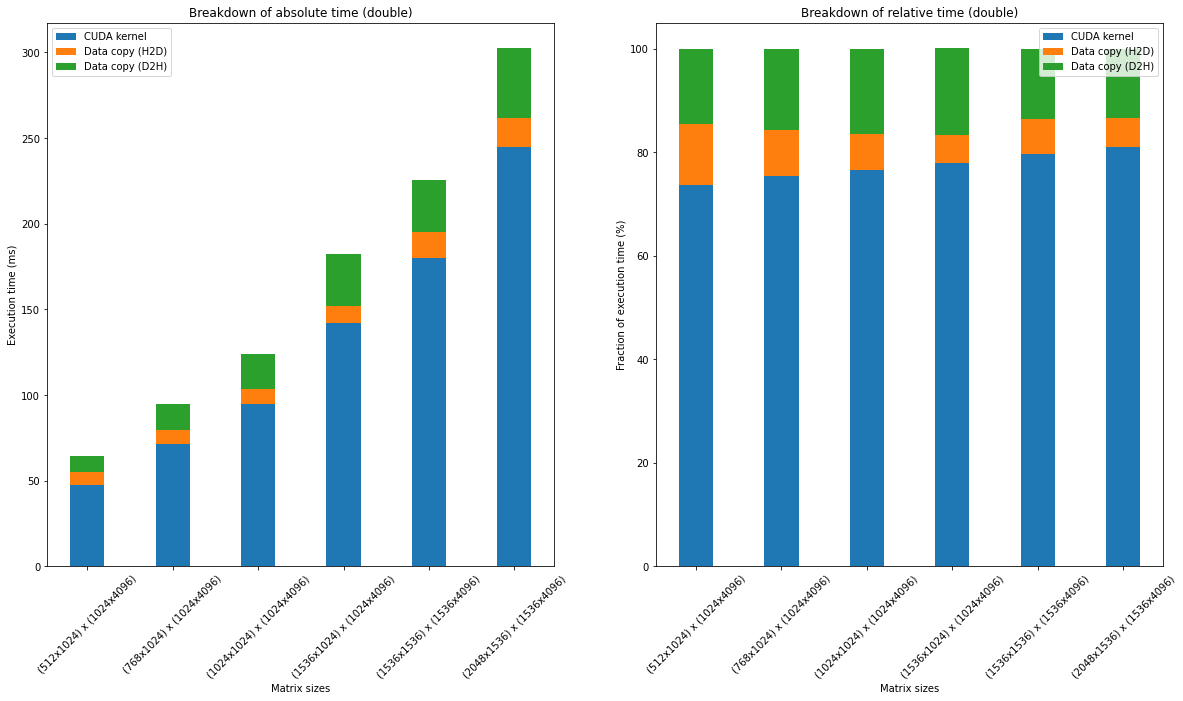

In [ ]:
# DATATYPE DOUBLE
import matplotlib.pyplot as plt
import numpy as np

matrix_sizes = ['(512x1024) x (1024x4096)', '(768x1024) x (1024x4096)', '(1024x1024) x (1024x4096)',
                '(1536x1024) x (1024x4096)', '(1536x1536) x (1536x4096)', '(2048x1536) x (1536x4096)']
cuda_kernel_abs = np.array([47.401, 71.125, 94.712, 142.07, 179.91, 244.97])
datacpy_d2h_abs = np.array([9.4017, 14.889, 20.438, 30.584, 30.605, 40.466])
datacpy_h2d_abs = np.array([7.5947, 8.4505, 8.6178, 9.6579, 15.154, 16.806])

cuda_kernel_rel = np.array([73.61, 75.29, 76.52, 77.93, 79.72, 81.05])
datacpy_d2h_rel = np.array([14.60, 15.76, 16.51, 16.78, 13.56, 13.39])
datacpy_h2d_rel = np.array([11.79,  8.95,  6.96,  5.30,  6.72,  5.56])

width = 0.4
fig, ax = plt.subplots(1, 2)

ax[0].bar(matrix_sizes, cuda_kernel_abs, width, label='CUDA kernel')
ax[0].bar(matrix_sizes, datacpy_h2d_abs, width, bottom=cuda_kernel_abs,
       label='Data copy (H2D)')
ax[0].bar(matrix_sizes, datacpy_d2h_abs, width, bottom=datacpy_h2d_abs+cuda_kernel_abs,
       label='Data copy (D2H)')

ax[0].set_xlabel('Matrix sizes')
ax[0].set_ylabel('Execution time (ms)')
ax[0].set_title('Breakdown of absolute time (double)')
ax[0].legend()

ax[1].bar(matrix_sizes, cuda_kernel_rel, width, label='CUDA kernel')
ax[1].bar(matrix_sizes, datacpy_h2d_rel, width, bottom=cuda_kernel_rel,
       label='Data copy (H2D)')
ax[1].bar(matrix_sizes, datacpy_d2h_rel, width, bottom=datacpy_h2d_rel+cuda_kernel_rel,
       label='Data copy (D2H)')

ax[1].set_xlabel('Matrix sizes')
ax[1].set_ylabel('Fraction of execution time (%)')
ax[1].set_title('Breakdown of relative time (double)')
ax[1].legend()

for tick in ax[0].get_xticklabels():
    tick.set_rotation(45)
for tick in ax[1].get_xticklabels():
    tick.set_rotation(45)
fig.set_size_inches(20, 10, forward=True)
plt.show()

## Further measurements for hw_4/ex_3 based on code of hw_3/ex_2

In [ ]:
!nvcc -arch=sm_75 ./lab3_ex2.cu -o lab3_ex2
!nvprof ./lab3_ex2 512 1024 1024 4096

Input matrix dim (512 x 1024) (1024 x 4096) (512 x 4096)
==3655== NVPROF is profiling process 3655, command: ./lab3_ex2 512 1024 1024 4096
CPU and GPU results are equal.
==3655== Profiling application: ./lab3_ex2 512 1024 1024 4096
==3655== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   70.09%  18.751ms         1  18.751ms  18.751ms  18.751ms  gemm(float*, float*, float*, int, int, int, int)
                   15.66%  4.1885ms         1  4.1885ms  4.1885ms  4.1885ms  [CUDA memcpy DtoH]
                   14.25%  3.8130ms         2  1.9065ms  315.29us  3.4978ms  [CUDA memcpy HtoD]
      API calls:   91.23%  312.48ms         3  104.16ms  91.842us  312.27ms  cudaMalloc
                    8.30%  28.444ms         3  9.4813ms  499.13us  24.211ms  cudaMemcpy
                    0.30%  1.0129ms         3  337.64us  129.57us  749.80us  cudaFree
                    0.10%  349.20us         1  349.20us  349.20us  349.20us  cu

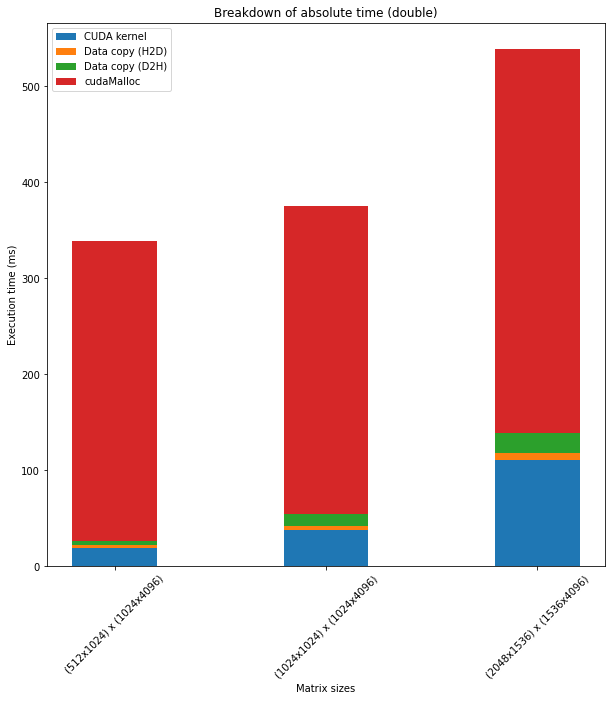

In [ ]:
# hw_4/ex_3
# DATATYPE FLOAT
import matplotlib.pyplot as plt
import numpy as np

matrix_sizes = ['(512x1024) x (1024x4096)', '(1024x1024) x (1024x4096)', '(2048x1536) x (1536x4096)']
cuda_kernel_abs = np.array([18.751, 37.406, 110.72])
datacpy_d2h_abs = np.array([4.1885, 12.925, 20.011])
datacpy_h2d_abs = np.array([3.8130, 4.3679, 7.7878])
cudaMalloc_abs = np.array([312.48, 320.93, 400.65])

width = 0.4
fig, ax = plt.subplots(1, 1)

ax.bar(matrix_sizes, cuda_kernel_abs, width, label='CUDA kernel')
ax.bar(matrix_sizes, datacpy_h2d_abs, width, bottom=cuda_kernel_abs,
       label='Data copy (H2D)')
ax.bar(matrix_sizes, datacpy_d2h_abs, width, bottom=datacpy_h2d_abs+cuda_kernel_abs,
       label='Data copy (D2H)')
ax.bar(matrix_sizes, cudaMalloc_abs, width, bottom=datacpy_d2h_abs+datacpy_h2d_abs+cuda_kernel_abs,
       label='cudaMalloc')

ax.set_xlabel('Matrix sizes')
ax.set_ylabel('Execution time (ms)')
ax.set_title('Breakdown of absolute time (double)')
ax.legend()

for tick in ax.get_xticklabels():
    tick.set_rotation(45)
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
fig.set_size_inches(20/2, 10, forward=True)
plt.show()